# Finding the magnetic dipole position with a convolutional neural net

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis

In [2]:
from sklearn.externals import joblib

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Reshape, Lambda, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers
from keras.optimizers import Adam

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tqdm import TQDMNotebookCallback
import time

from keras.utils.vis_utils import plot_model

# from keras.applications import InceptionV3
# from keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2

from glob import glob
from joblib import Parallel, delayed

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# ?preprocess_input

## Instructions for notebook

The note book can be executed from top to bottom and it generates some output that allows to understand the how the data and models where generated
The outputs are:
  1. data as .h5 file magnet settings as a .json file in '../data/' folder
  2. the model as a .h5 file in '../models/' folder
  3. the notebook as a .html file for future reference in '../html/' folder


Modify `generate_data()` to randomly change the z position and angles in addition to the x and y position.

**2019-01-21**: data for random xy positions with 2000 datapoints and shotnoise level 1, `tag = 'shot_noise_1_xy'`




**show available data sets**

In [5]:
[f.split('/')[-1].split('_train')[0] for f in glob('../data/*train*.h5')]

[]

In [6]:
# X.shape

### global notebook setting

In [427]:
calculate_data = True ## if true, data gets generated and saved to disk, if false load previous data from disk

calculate_learning_curve = False

n_train = 5000  # number of training examples (calculate_data=True)

n_val = 200  # number of validation examples (calculate_data=True)

**set tag to describe current experiment**

In [428]:
# tag = 'shot_noise_2_xyzt'
tag = 'shot_noise_0_xyztp'

time_stamp = time.strftime('%Y%m%d-%H%M', time.localtime()) 
time_stamp

'20190129-0658'

In [429]:
i = 0
while True:
    filename = '../data/' + tag + '_--type--_{:03d}'.format(i)
    if not os.path.isfile(filename.replace('--type--', 'train')+'.h5'):
        break
    else:
        i += 1
print(filename)

../data/shot_noise_0_xyztp_--type--_001


## Problem description

we ceate images of a circle with fixed linethickness and varying position and try to get the center position of the circle by fitting to a convolutional neural net

if the data has been generated before jump directly to  [load data](#load_data)



In [430]:
magnet_parameters = {
    'particle_radius':19,
    'nv_radius':67, # 73.670
    'theta_mag': 0,
    'phi_mag': 60,
    'dipole_height':80,
    'shot_noise':0,
    'linewidth':1e7,
    'n_angle':48, # 45 48
    'n_freq':448,  # 351
    'f_min':2.62e9, #, 2.695
    'f_max':3.120e9, #, 3.045
    'avrg_count_rate':1
}



def create_image(xo, yo, plot_img=False, particle_radius=20, nv_radius=70, theta_mag=0, phi_mag=45,
                                              dipole_height=80, shot_noise=0, linewidth=1e7,
                                              n_angle=60, n_freq=300,
                                              f_min=2.65e9, f_max=3.15e9,
                                              avrg_count_rate=100):
    """
    xo, yo center of the circle
    """
    
    signal = nv_analysis.esr_2D_map_ring_scan(nv_x=xo, nv_y=yo,
                                              particle_radius=particle_radius, nv_radius=nv_radius, theta_mag=theta_mag,
                                              phi_mag=phi_mag,dipole_height=dipole_height, shot_noise=shot_noise,
                                              linewidth=linewidth,n_angle=n_angle, n_freq=n_freq,
                                              f_min=f_min, f_max=f_max,avrg_count_rate=avrg_count_rate,
                                              return_data=True, show_plot=plot_img)


        
    return signal

In [431]:
nmax = 1000000
c1 = 1000
shot_noise=300
x = np.random.poisson(lam=c1*shot_noise, size=nmax) / shot_noise
# x2 = np.random.poisson(lam=c1, size=nmax) / np.sqrt(shot_noise)
np.std(x)/c1, 1/(np.sqrt(c1)*np.sqrt(shot_noise))

(0.0018260330248643956, 0.0018257418583505537)

## create the test data

In [432]:
def worker_function(parameters, pbar = None):

    img = create_image(**parameters)  # calculate the image
    if pbar:
        pbar.update()  # update the progress
    return img  # return the image


def generate_data(n_data, parameters=None, n_jobs=2):

    max_displacement = 20 ## maximum offset from the center 
    # positive and negative values
    positions = pd.DataFrame(max_displacement * (np.random.random((n_data, 2))-0.5),columns = ['xo', 'yo'])
    
    positions['dipole_height'] = 20*(np.random.random((n_data)))+60
    positions['theta_mag'] = 90*(np.random.random((n_data)))
    positions['phi_mag'] = 90*(np.random.random((n_data)))

    X = Parallel(n_jobs=n_jobs, backend='multiprocessing')(delayed(worker_function)({**parameters, **positions.iloc[i].to_dict()})
                                                       for i in tqdm(range(len(positions))))
    X = np.array(X,dtype=np.float16)
    
    Y = positions.values
    
    labels = positions.columns

    
    x_scaler = MinMaxScaler()
    # Xs = scaler.fit_transform(X.reshape(len(X), -1).astype(np.float32))
    x_scaler.fit(np.expand_dims(X.flatten().astype(np.float32), axis=1))  # flatten the array so that min_max scaling over full data and not for each feature (pixel)
    
    y_scaler = MinMaxScaler()
    y_scaler.fit(Y)
    
    
#     x_shape = X.shape

#     X = X.reshape(X.shape[0], -1)


#     # scale inputs and outputs
#     if x_scaler is None:
#         x_scaler = MinMaxScaler()
#     if y_scaler is None:
#         y_scaler = MinMaxScaler()

#     X = x_scaler.fit_transform(X)
#     Y = y_scaler.fit_transform(Y)


#     print(x_shape)
#     # reshape to add last dimension 1 - for greyscale images
#     X = X.reshape(*x_shape, 1)
    
    
    return {'X':X, 'Y' :Y, 'labels':labels, 'y_scaler':y_scaler, 'x_scaler':x_scaler}




In [433]:
if calculate_data:

    print('generate training set')
    train_set = generate_data(n_train, parameters=magnet_parameters, n_jobs=3)

    X, Y = train_set['X'], train_set['Y']

  0%|          | 0/5000 [00:00<?, ?it/s]

generate training set


100%|██████████| 5000/5000 [40:02<00:00,  2.08it/s] 


In [434]:
x_scaler, y_scaler = train_set['x_scaler'], train_set['y_scaler']

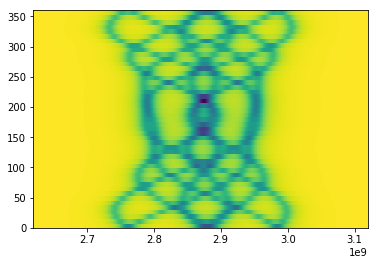

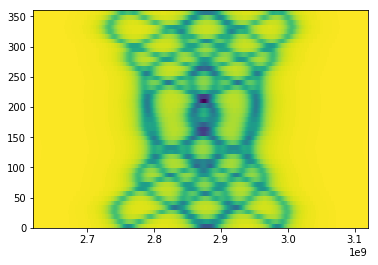

In [435]:
if calculate_data:
    f_min=magnet_parameters['f_min']
    f_max=magnet_parameters['f_max']
    n_angle=magnet_parameters['n_angle']
    n_freq=magnet_parameters['n_freq']
    frequencies = np.linspace(f_min, f_max, n_freq)
    angle = np.linspace(0, 360, n_angle)
#     img = x_scaler.inverse_transform(X.reshape(len(X), -1)).reshape(x_shape[0:-1])[0]
    img = X[0]
    plt.pcolor(frequencies, angle, img)
    
    plt.figure()
    
    
    img = x_scaler.transform(np.expand_dims(img.flatten(), axis=1)).reshape(img.shape)
    plt.pcolor(frequencies, angle, img)
# plt.pcolor(frequencies, angle, X[0,:,:,0])

In [436]:
if calculate_data:
    print('genrate validation set')
    val_set = generate_data(n_val, n_jobs=3, parameters=magnet_parameters)

  0%|          | 0/200 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


### save the data set to disk

In [443]:
if calculate_data:
    print('saving the parameters (' + tag + ')')
    with open(filename.replace('--type--', 'parameters')+'.json', 'w') as outfile:
        json.dump(magnet_parameters, outfile)

saving the parameters (shot_noise_0_xyztp)


In [438]:
val_set['y_scaler']

MinMaxScaler(copy=True, feature_range=(0, 1))

In [439]:
if calculate_data:
    print('saving the validation data (' + filename.replace('--type--', 'validation')+'.h5' + ')')
    
    hf = h5py.File(filename.replace('--type--', 'validation')+'.h5', 'w')
    hf.create_dataset("X",data=val_set['X'])
    hf.create_dataset("Y",data =val_set['Y'])
    hf.close()

saving the validation data (shot_noise_0_xyztp)


In [440]:


if calculate_data:

    print('saving the scalers data (' + filename.replace('--type--', 'x_scaler') + ')')
    joblib.dump(train_set['x_scaler'], filename.replace('--type--', 'x_scaler') + '.save') 
    joblib.dump(train_set['y_scaler'], filename.replace('--type--', 'y_scaler') + '.save') 

saving the scalers data (shot_noise_0_xyztp)


In [441]:
if calculate_data:

    print('saving the training data (' + filename.replace('--type--', 'train')+'.h5' + ')')

    hf = h5py.File(filename.replace('--type--', 'train')+'.h5', 'w')
    hf.create_dataset("X",data=train_set['X'])
    hf.create_dataset("Y",data =train_set['Y'])
    hf.close()

saving the training data (shot_noise_0_xyztp)


In [445]:
if calculate_data:
    print('saving the labels (' + filename.replace('--type--', 'labels') + '.txt' + ')')
    #Creating .csv file. 
    labels = open(filename.replace('--type--', 'labels') + '.txt',"w")
    labels.write(','.join(list(train_set['labels'])))
    labels.close()

saving the labels (../data/shot_noise_0_xyztp_labels_001.txt)


## load the data 
<a id="load_data"></a>

In [332]:
data_subfolder = 'min_max/'
data_subfolder = ''

In [444]:
filename

'../data/shot_noise_0_xyztp_--type--_001'

In [334]:
[f.split('/')[-1].split('_train')[0] for f in glob('../data/'+data_subfolder+'*train*.h5')]

['shot_noise_0_xyztp']

In [335]:
filename = '../data/'+data_subfolder+'shot_noise_0_xyz_--type--_000'
filename = '../data/'+data_subfolder+'shot_noise_0_xyztp_--type--_000'
tag = filename.split('_--type')[0].split('/')[-1]

In [336]:
with open(filename.replace('--type--', 'parameters')+'.json', 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

{'particle_radius': 19,
 'nv_radius': 67,
 'theta_mag': 0,
 'phi_mag': 60,
 'dipole_height': 80,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 48,
 'n_freq': 448,
 'f_min': 2620000000.0,
 'f_max': 3120000000.0,
 'avrg_count_rate': 1}

In [337]:
hf = h5py.File(filename.replace('--type--', 'validation')+'.h5', 'r')
val_set = {k: np.array(hf.get(k)) for k in hf.keys()}
hf.close()

In [338]:
with open(filename.replace('--type--', 'labels') + '.txt',"r") as filein:
    labels = filein.read().split(',')
labels

['xo', 'yo', 'dipole_height', 'theta_mag', 'phi_mag']

In [339]:
hf = h5py.File(filename.replace('--type--', 'train')+'.h5', 'r')
train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
train_set['x_scaler'] = joblib.load(filename.replace('--type--', 'x_scaler') + '.save')  
train_set['y_scaler'] = joblib.load(filename.replace('--type--', 'y_scaler') + '.save') 
hf.close()

In [447]:
X, Y = train_set['X'], train_set['Y']

In [448]:
# x_scaler, y_scaler = train_set['x_scaler'], train_set['y_scaler']
added_noise = 0.003
noise = added_noise*np.random.randn(*X.shape)
X = X + noise

In [449]:
Y.shape, X.shape

((5000, 5), (5000, 48, 448))

In [450]:
X.mean(), X.min(), X.max(), X.std(dtype=np.float64)

(0.9778523637604828,
 0.7926648843725044,
 1.0165188211731115,
 0.028009817034211515)

(array([3.3230000e+03, 3.6179000e+04, 1.1940000e+05, 4.0612400e+05,
        1.7399040e+06, 5.2012850e+06, 1.1262863e+07, 1.4778218e+07,
        2.5777444e+07, 4.8195260e+07]),
 array([0.79266488, 0.81505028, 0.83743567, 0.85982107, 0.88220646,
        0.90459185, 0.92697725, 0.94936264, 0.97174803, 0.99413343,
        1.01651882]),
 <a list of 10 Patch objects>)

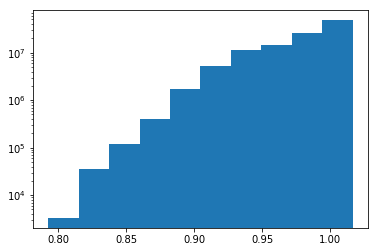

In [451]:
plt.hist(X.flatten(), log=True)

([array([478., 522.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([477., 523.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 501., 494.,   5.]),
  array([  0.,  97., 115., 108., 104., 104., 122., 112., 124., 114.]),
  array([  0., 110., 116., 110., 112., 115., 116.,  96., 119., 106.])],
 array([-9.99125735e+00, -1.22291883e-04,  9.99101276e+00,  1.99821478e+01,
         2.99732829e+01,  3.99644179e+01,  4.99555530e+01,  5.99466880e+01,
         6.99378231e+01,  7.99289581e+01,  8.99200932e+01]),
 <a list of 5 Lists of Patches objects>)

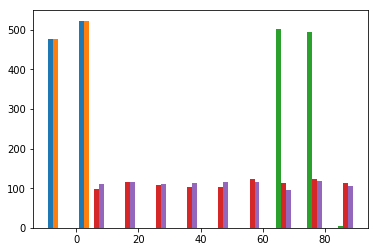

In [345]:
plt.hist(Y)

([array([ 96., 104.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 86., 113.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,  95.,   5.]),
  array([ 0., 26., 15., 22., 16., 33., 20., 19., 25., 24.]),
  array([ 0., 20., 21., 25., 16., 32., 19., 22., 21., 24.])],
 array([-9.97355371e+00, -2.24540984e-02,  9.92864552e+00,  1.98797451e+01,
         2.98308447e+01,  3.97819444e+01,  4.97330440e+01,  5.96841436e+01,
         6.96352432e+01,  7.95863428e+01,  8.95374424e+01]),
 <a list of 5 Lists of Patches objects>)

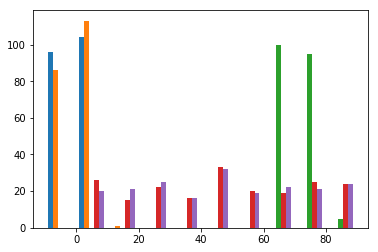

In [452]:
plt.hist(val_set['Y'])

## fit the scaler and split data into test and training set

one option is to load the scaler that was computed previously, or make a new scaler

In [453]:
# scaler for option 1 (feature wise)

x_shape = X.shape

x_scaler = MinMaxScaler()


x_scaler.fit(X.reshape(X.shape[0], -1).astype(np.float32))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [313]:
# # option 2
# x_scaler = MinMaxScaler()
# # Xs = scaler.fit_transform(X.reshape(len(X), -1).astype(np.float32))
# x_scaler.fit(np.expand_dims(X.flatten().astype(np.float32), axis=1))  # flatten the array so that min_max scaling over full data and not for each feature (pixel)

    

MinMaxScaler(copy=True, feature_range=(0, 1))

In [510]:
# class ESRScaler():
#     def __init__()
def esr_preprocessing(X):
    """
    
    esr has dips
    here we subtract each esr map from its mean to obtain maps that have peaks instead of dips
    
    X: matrix with dimensions (None, n_freq, n_angle) containing the esr data
    """
    
    x_shape = X.shape
    assert len(x_shape)==3
    
    mean = np.mean(X.reshape(x_shape[0], -1), axis=1)
    
    return np.repeat(mean, np.product(x_shape[1:])).reshape(x_shape)-X

Xs = esr_preprocessing(X[0:3])

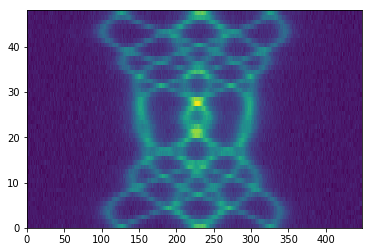

In [511]:
plt.pcolor(Xs[0])

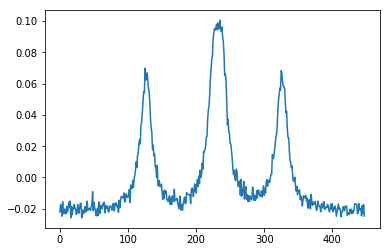

In [480]:
plt.plot(Xs[0, 0])

In [512]:

def get_x_scaler(X, option=0):
    
    if option==0:
        x_scaler = None
    elif option==1:
        # option 1 (feature wise)
        x_shape = X.shape
        x_scaler = MinMaxScaler()
        x_scaler.fit(X.reshape(Xs.shape[0], -1).astype(np.float32))
    elif option==2:
        # option 2 (global)
        x_scaler = MinMaxScaler()
        x_scaler.fit(np.expand_dims(X.flatten().astype(np.float32), axis=1))  # flatten the array so that min_max scaling over full data and not for each feature (pixel)

    return x_scaler



def split_and_scale(X, Y, x_scaler, y_scaler, test_size, option = 2):
    """
    
    
    added_noise: if larger than 0, add normal distributed noise with std dev `added_noise` to X
    
    """

    
    x_shape = X.shape
    
    Xs=X
    
    if option==0:
        pass
    elif option==1:
        # option 1 (feature wise)
        Xs = x_scaler.transform(Xs.reshape(x_shape[0], -1).astype(np.float32))
    elif option==2:
        # option 2 (global)
        Xs = x_scaler.transform(np.expand_dims(Xs.flatten().astype(np.float32), axis=1))  # flatten the array so that min_max scaling over full data and not for each feature (pixel)

    Xs = Xs.reshape(x_shape)
    Ys = y_scaler.transform(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=test_size, random_state=42)
    
    X_train = np.expand_dims(X_train, -1)  # add additional dimension 
    X_test = np.expand_dims(X_test, -1)
    
    return X_train, X_test, Y_train, Y_test

## CNN model - image in >> positions out

In [494]:
# define base model
def baseline_model(input_shape, batch_norm=False):
    """VGG inspired model"""
    #create model
    model = Sequential()
    
    use_bias = batch_norm == False  # if batch_norm don't use bias
    #add model layers
    model.add(Conv2D(filters = 64, kernel_size=(3,3), use_bias=use_bias,  input_shape=(*input_shape, 1)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(filters = 128, kernel_size=(3,3), use_bias=use_bias))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(filters = 256, kernel_size=(3,3), use_bias=use_bias))
#     if batch_norm:
#         model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 256, kernel_size=(3,3), use_bias=use_bias))
#     if batch_norm:
#         model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
#     model.add(Dropout(rate=0.2))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(Y.shape[1]))
#     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam') # , metrics=['mse']
    return model
              
              
              
              
# define base model
# def baseline_model():
    
#     #create model
#     model = Sequential()
#     #add model layers
#     model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# #     model.add(Dropout(0.5))
#     model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
# #     model.add(Conv2D(2, kernel_size=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 256, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
# #     
    
#     model.add(Flatten())
#     model.add(Dense(100))
#     model.add(Dropout(0.5))
#     model.add(Dense(Y.shape[1]))
# #     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
#     return model
              


In [534]:
model = baseline_model(input_shape=X.shape[1:])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 46, 446, 64)       640       
_________________________________________________________________
activation_43 (Activation)   (None, 46, 446, 64)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 23, 223, 64)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 21, 221, 128)      73856     
_________________________________________________________________
activation_44 (Activation)   (None, 21, 221, 128)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 110, 128)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 108, 256)       295168    
__________

### train the model - using Keras API

In [496]:
# class CustomScaler():
    
#     def __init__(self, X, axis=None):
#         self.width = X.std(dtype=np.float64,axis=axis)
#         self.mean  = X.mean(axis=axis)
#         self.axis = axis
            
# #     def __repr__(self):
# #         return self.__str__()
# #     def  __str__(self):
# #         return 'CustomScaler\n width={:0.3f}\t mean={:0.3f}'.format(self.width, self.mean)
        
#     def transform(self, X):
#         return (X-self.mean) / self.width
#     def inverse_transform(self, Y):
#         return (Y*self.width + self.mean) 

# scaler_x = CustomScaler(X)
# scaler_y = CustomScaler(Y, axis=0)

In [497]:
# scaler_y.width, scaler_y.mean

In [498]:
# scaler_x = MinMaxScaler(X)
# scaler_y = CustomScaler(Y, axis=0)

In [499]:
# Y.mean(axis=0), Y.std(axis=0)


In [355]:
# x_shape = X.shape

# X = X.reshape(X.shape[0], -1)

# print(X.shape)

# x_scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()

# X = x_scaler.fit_transform(X.astype(np.float64))
# Y = y_scaler.fit_transform(Y.astype(np.float64))


# print(x_shape)
# # reshape to add last dimension 1 - for greyscale images
# X = X.reshape(*x_shape, 1)

In [457]:
model

6195077

In [524]:
added_noise = 0.005

scaler_option = 2


noise = added_noise*np.random.randn(*X.shape)
Xs = X + noise
Xs = esr_preprocessing(Xs)  

x_scaler = get_x_scaler(Xs, option=scaler_option)

In [525]:
X_train, X_test, Y_train, Y_test = split_and_scale(Xs, Y, x_scaler, y_scaler, test_size=0.1,
                                                   option=scaler_option)

In [526]:
X_train.shape

(4500, 48, 448, 1)

In [527]:
X_train.min(), X_train.max()

(0.0, 1.0)

In [528]:
Y_train.min(), Y_train.max()

(0.0, 1.0000000000000004)

In [529]:
# X_train = scaler_x.transform(X_train)
# X_test = scaler_x.transform(X_test)

# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)

# Y_train = scaler_y.transform(Y_train)
# Y_test = scaler_y.transform(Y_test)

([array([0.86056696, 1.30085704, 0.92060652, 0.92060652, 0.84055378,
         1.080712  , 1.02067244, 1.20079111, 0.98064607, 0.88058015]),
  array([1.20079111, 1.14075156, 0.76050104, 0.92060652, 0.84055378,
         0.82054059, 1.080712  , 1.42093615, 0.72047467, 1.10072518]),
  array([0.88058015, 0.80052741, 0.98064607, 1.06069881, 0.98064607,
         1.06069881, 0.82054059, 1.14075156, 1.10072518, 1.18077793]),
  array([0.9406197 , 0.9406197 , 1.02067244, 1.14075156, 0.86056696,
         0.88058015, 1.34088341, 1.04068563, 1.00065926, 0.84055378]),
  array([0.90059333, 1.080712  , 0.82054059, 1.12073837, 0.88058015,
         0.96063289, 1.04068563, 0.84055378, 1.34088341, 1.02067244])],
 array([6.58824749e-04, 1.00592942e-01, 2.00527060e-01, 3.00461177e-01,
        4.00395295e-01, 5.00329412e-01, 6.00263530e-01, 7.00197647e-01,
        8.00131765e-01, 9.00065882e-01, 1.00000000e+00]),
 <a list of 5 Lists of Patches objects>)

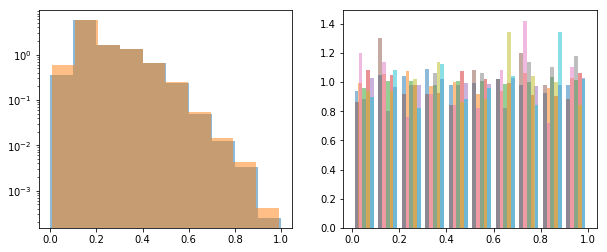

In [530]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].hist(X_train.flatten(), density=True, alpha=0.5, log=True)
ax[0].hist(X_test.flatten(), density=True, alpha=0.5, log= True)


ax[1].hist(Y_train, density=True, alpha=0.5)
ax[1].hist(Y_test, density=True, alpha=0.5)

([array([0.86056696, 1.30085704, 0.92060652, 0.92060652, 0.84055378,
         1.080712  , 1.02067244, 1.20079111, 0.98064607, 0.88058015]),
  array([1.20079111, 1.14075156, 0.76050104, 0.92060652, 0.84055378,
         0.82054059, 1.080712  , 1.42093615, 0.72047467, 1.10072518]),
  array([0.88058015, 0.80052741, 0.98064607, 1.06069881, 0.98064607,
         1.06069881, 0.82054059, 1.14075156, 1.10072518, 1.18077793]),
  array([0.9406197 , 0.9406197 , 1.02067244, 1.14075156, 0.86056696,
         0.88058015, 1.34088341, 1.04068563, 1.00065926, 0.84055378]),
  array([0.90059333, 1.080712  , 0.82054059, 1.12073837, 0.88058015,
         0.96063289, 1.04068563, 0.84055378, 1.34088341, 1.02067244])],
 array([6.58824749e-04, 1.00592942e-01, 2.00527060e-01, 3.00461177e-01,
        4.00395295e-01, 5.00329412e-01, 6.00263530e-01, 7.00197647e-01,
        8.00131765e-01, 9.00065882e-01, 1.00000000e+00]),
 <a list of 5 Lists of Patches objects>)

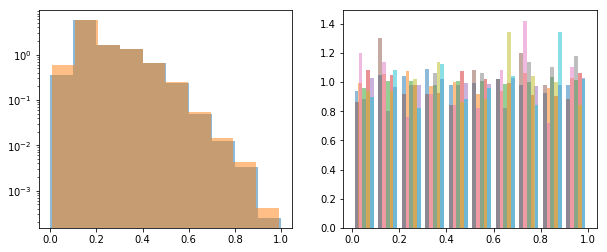

In [531]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].hist(X_train.flatten(), density=True, alpha=0.5, log=True)
ax[0].hist(X_test.flatten(), density=True, alpha=0.5, log= True)


ax[1].hist(Y_train, density=True, alpha=0.5)
ax[1].hist(Y_test, density=True, alpha=0.5)

([array([0.04784241, 0.05224632, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]),
  array([0.04774232, 0.0523464 , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.05014445, 0.04944383, 0.00050044]),
  array([0.        , 0.00970861, 0.0115102 , 0.01080958, 0.01040923,
         0.01040923, 0.01221082, 0.01120994, 0.012411  , 0.01141012]),
  array([0.        , 0.01100976, 0.01161029, 0.01100976, 0.01120994,
         0.0115102 , 0.01161029, 0.00960852, 0.01191056, 0.01060941])],
 array([-9.99125735e+00, -1.22291883e-04,  9.99101276e+00,  1.99821478e+01,
         2.99732829e+01,  3.99644179e+01,  4.99555530e+01,  5.99466880e+01,
         6.99378231e+01,  7.99289581e+01,  8.99200932e+01]),
 <a list of 5 Lists of Patches objects>)

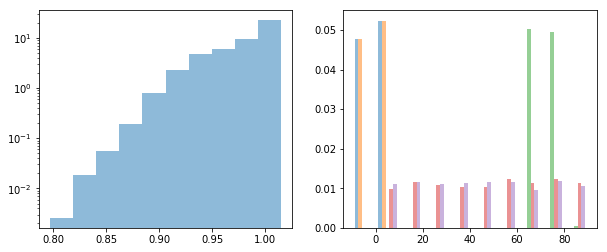

In [363]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].hist(X.flatten(), density=True, alpha=0.5, log=True)
ax[1].hist(Y, density=True, alpha=0.5)

In [535]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
    LossHistory(),
    TQDMNotebookCallback(leave_inner=False, leave_outer=True)
]

history = model.fit(X_train,Y_train, epochs=64, batch_size=32,verbose=0,
#                     validation_split=0.2,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks)
# history = model.fit(X[0:200],Y[0:200], epochs=100, batch_size=32,verbose=1, validation_data=(val_set['X'], val_set['Y']))

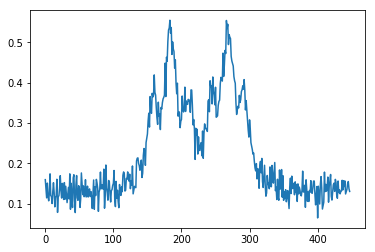

In [536]:
plt.plot(X_train[0,10])

Text(0,0.5,'mean squared error')

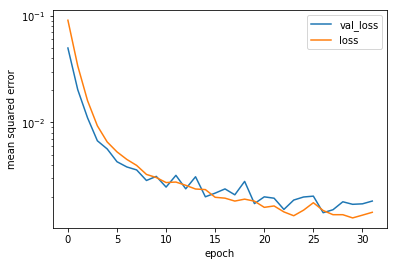

In [537]:
for value in ['val_loss', 'loss']:
    plt.semilogy(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

In [538]:
val_set['X'].min(),val_set['X'].max()

(0.798, 0.9995)

### save the model

In [539]:
model.save('../models/'+tag+'_model.h5')
print('../models/' + time_stamp + '_' +tag+'_model.h5 saved')

../models/20190129-0658_shot_noise_0_xyztp_model.h5 saved


In [540]:
f ='../models/'+tag+'_model.h5'

print('saving the scalers data ('+ f.replace('_model.h5', '_x_scaler.save')+ ')');
joblib.dump(x_scaler,f.replace('_model.h5', '_x_scaler.save'));
print('saving the scalers data ('+ f.replace('_model.h5', '_y_scaler.save')+ ')');
joblib.dump(y_scaler,f.replace('_model.h5', '_y_scaler.save'));

saving the scalers data (../models/shot_noise_0_xyztp_x_scaler.save)
saving the scalers data (../models/shot_noise_0_xyztp_y_scaler.save)


### learning curve
we use the keras wrapper for sklearn to be able to use the sklearn function

In [46]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold

In [57]:
from sklearn.model_selection import ShuffleSplit

In [58]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    fig = plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=2)
#     exploit_incremental_learning=True)
    train_scores_mean = np.abs(np.mean(train_scores, axis=1))  # when the score is a negative function
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.abs(np.mean(test_scores, axis=1))  # when the score is a negative function
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.loglog(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.loglog(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return fig, {'train_scores_mean':train_scores_mean,
                 'train_scores_std':train_scores_std,
                 'test_scores_mean':test_scores_mean,
                'test_scores_std':test_scores_std}






In [59]:
train_sizes= [int(x) for x in 2**np.arange(4,11)]
train_sizes

[16, 32, 64, 128, 256, 512, 1024]

In [60]:
%%time
if calculate_learning_curve:
    
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    model_reg = KerasRegressor(build_fn=baseline_model, epochs=16, batch_size=32, verbose=0)

    fig, data_learn = plot_learning_curve(model_reg, 'learning curve', X, Y, cv=cv, train_sizes=train_sizes)
    
    fig.savefig('../images/'+tag+'_learning_curve.jpg')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


In [61]:
# # plt.loglog(train_sizes, -data_learn['train_scores_mean'])
# # plt.loglog(train_sizes, -data_learn['test_scores_mean'])

# train_scores_mean = -data_learn['train_scores_mean']
# train_scores_std = data_learn['train_scores_std']
# test_scores_mean = -data_learn['test_scores_mean']
# test_scores_std = data_learn['test_scores_std']

# fig = plt.figure()
# plt.grid()

# plt.loglog(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.loglog(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")


# plt.legend(loc="best")
# plt.xlabel('number of training data')
# plt.ylabel('mean squared error')

# fig.savefig('../images/'+tag+'_learning_curve.jpg')

### show how well the model fits
#### on the training data

In [263]:
# load_model
from keras.models import load_model
model = load_model('../models/'+tag+'_model.h5')

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 446, 64)       640       
_________________________________________________________________
activation_8 (Activation)    (None, 46, 446, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 223, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 221, 128)      73856     
_________________________________________________________________
activation_9 (Activation)    (None, 21, 221, 128)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 110, 128)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 108, 256)       295168    
__________

In [371]:

label_map = {'xo':'x', 'yo':'y', 'dipole_height':'z', 'theta_mag':'t', 'phi_mag':'p'}

def analyze_fit(X,Y,n_plot = 3, n_max = 20, x_scaler=None, y_scaler=None):

    
    if x_scaler:
        x_shape = X.shape
        Xs = x_scaler.transform(X.reshape(x_shape[0], -1).astype(np.float32)).reshape(x_shape)
    else:
        Xs=X

    if y_scaler:
        Ys = y_scaler.transform(Y)
    else:
        Ys = Y
        
        
    if Xs.shape[-1] != 1: #model expects a dimension for "color channels"
        Xs = np.expand_dims(Xs, -1)
        
    Y_predict = model.predict(Xs)
    
    for k, v in magnet_parameters.items():
        print(k, v)
    
    fig, ax = plt.subplots(1,2, figsize = (8,5))
        
    for i in range(len(Xs)):
        ax[0].plot([Ys[i, 0], Y_predict[i, 0]], [Ys[i, 1], Y_predict[i, 1]], 'go-', alpha=0.2)
        ax[0].set_xlabel('xo')
        ax[0].set_ylabel('yo')
    ax[0].scatter(Ys[:n_max, 0], Ys[:n_max, 1], marker='o')
    ax[0].scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
    ax[0].set_title('scaled outputs')
    
    
    if y_scaler:
        Y_real = y_scaler.inverse_transform(Ys)
        Y_pred_real = y_scaler.inverse_transform(Y_predict)
    else:
        Y_real = Ys
        Y_pred_real = Y_predict

        
    ax[1].scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
    ax[1].scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
    ax[1].set_xlabel('xo')
    ax[1].set_ylabel('yo')
    ax[1].set_title('physical outputs')
    
    
    

    f_min=magnet_parameters['f_min']
    f_max=magnet_parameters['f_max']
    n_angle=magnet_parameters['n_angle']
    n_freq=magnet_parameters['n_freq']
    frequencies = np.linspace(f_min, f_max, n_freq)
    angle = np.linspace(0, 360, n_angle)

    if x_scaler:
        x_shape = Xs.shape[0:-1]
        X_real = x_scaler.inverse_transform(Xs.reshape(x_shape[0], -1)).reshape(x_shape)
    else:
        X_real = Xs

    for i in range(n_plot):
        fig, ax  = plt.subplots(1, 2, figsize = (12,4))

        ax[0].pcolor(frequencies, angle, np.squeeze(X_real[i]))
        ax[0].set_title('real\n' + ', '.join([label_map[k] +'={:0.2f}' for k in labels]).format(*Y_real[i]))
        # and create the image, construction in second argument constructs the updates parameter dictionary
        img = create_image(*Y_pred_real[i, 0:2], **{**magnet_parameters, **{k:v for k, v in zip(labels[2:], Y_pred_real[i, 2:])}})
        ax[1].pcolor(frequencies, angle, img)
        ax[1].set_title('reconstructed\n' + ', '.join([label_map[k] +'={:0.2f}' for k in labels]).format(*Y_pred_real[i]))
        plt.tight_layout()

    
    

In [372]:
Y_train[0:n_max]

array([[0.5985455 , 0.36242868, 0.68898262, 0.6194911 , 0.85414799],
       [0.81039893, 0.36210217, 0.84154005, 0.93367544, 0.45464749],
       [0.22055073, 0.6773008 , 0.58686739, 0.50627807, 0.20682219],
       [0.29356691, 0.53993343, 0.53768725, 0.38253368, 0.00872537],
       [0.65381295, 0.77367927, 0.31947967, 0.35872013, 0.04472842],
       [0.88654421, 0.57525036, 0.05093311, 0.08847896, 0.82806716],
       [0.55402669, 0.91178497, 0.38606888, 0.36613501, 0.00222624],
       [0.07017607, 0.24627492, 0.1207593 , 0.40939446, 0.62105739],
       [0.3548046 , 0.10285966, 0.94456724, 0.24993196, 0.74112086],
       [0.80378767, 0.09442892, 0.53790785, 0.30630217, 0.20101968],
       [0.27565696, 0.10149969, 0.20341558, 0.7174846 , 0.77278735],
       [0.27226156, 0.871259  , 0.44104178, 0.32797673, 0.88645371],
       [0.62928462, 0.90971553, 0.75346689, 0.57045551, 0.78574684],
       [0.02867558, 0.37339465, 0.50273569, 0.53922574, 0.72589566],
       [0.12455473, 0.80442669, 0.

In [373]:
x_shape = X_train[0:n_max].shape
Xo = x_scaler.inverse_transform(X_train[0:n_max].reshape(x_shape[0], -1)).reshape(x_shape)
Yo = y_scaler.inverse_transform(Y_train[0:n_max])

particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


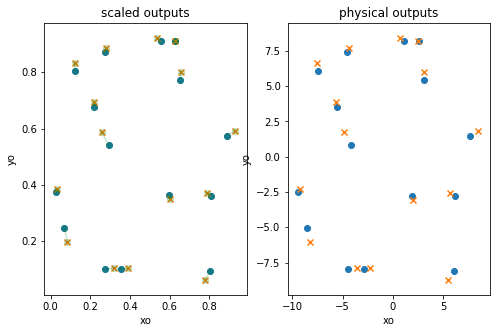

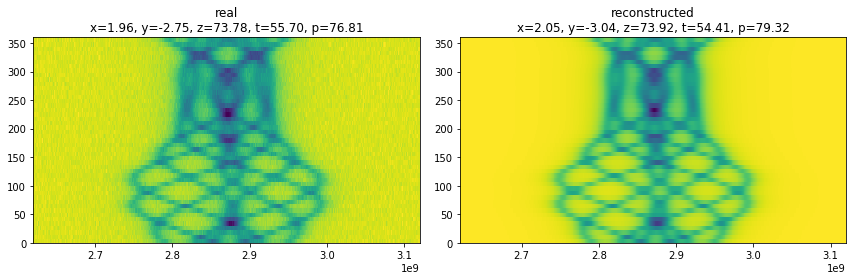

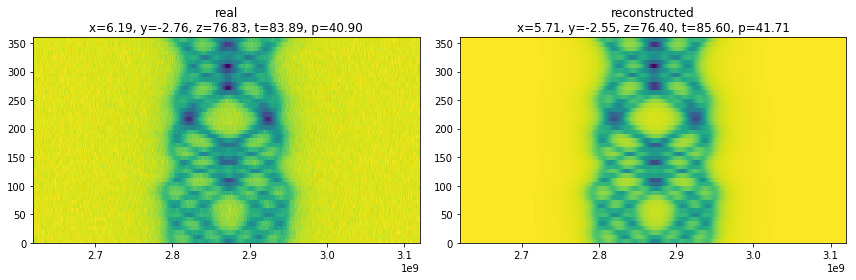

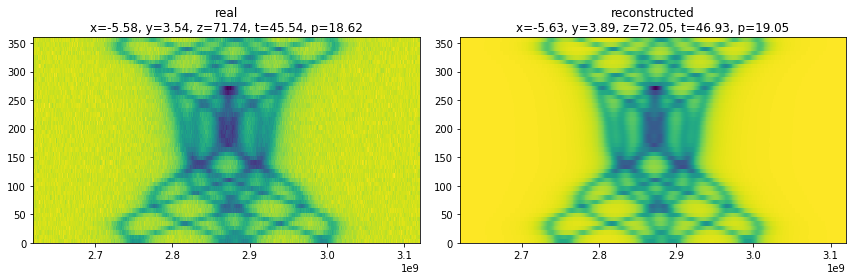

In [374]:
analyze_fit(Xo, Yo, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

In [375]:
Y_pred = model.predict(X_train)

Text(0.5,1,'error distribution on train set')

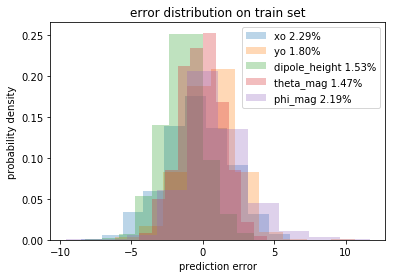

In [376]:
err = (Y_pred- Y_train)

for e, l in zip(err.T, labels):
    plt.hist(e*100, density=True, alpha=0.3, label = l+' {:0.2f}%'.format(100*np.std(e)))
plt.legend()
plt.xlabel('prediction error')
plt.ylabel('probability density')
plt.title('error distribution on train set')

#### on the test data

In [377]:
x_shape = X_test[0:n_max].shape
Xo = x_scaler.inverse_transform(X_test[0:n_max].reshape(x_shape[0], -1)).reshape(x_shape)
Yo = y_scaler.inverse_transform(Y_test[0:n_max])

particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


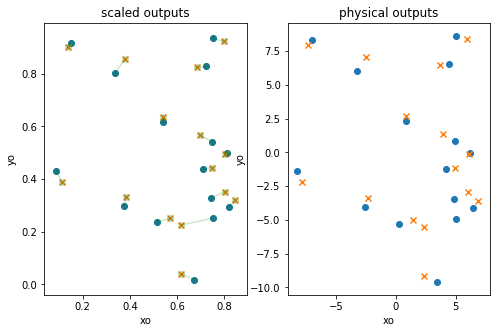

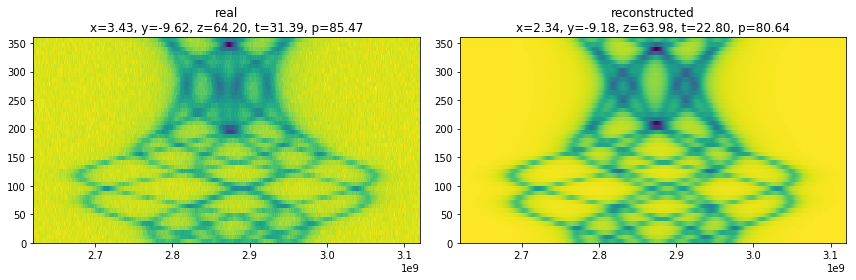

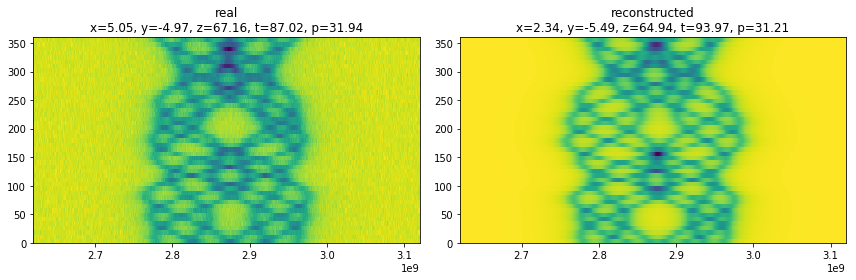

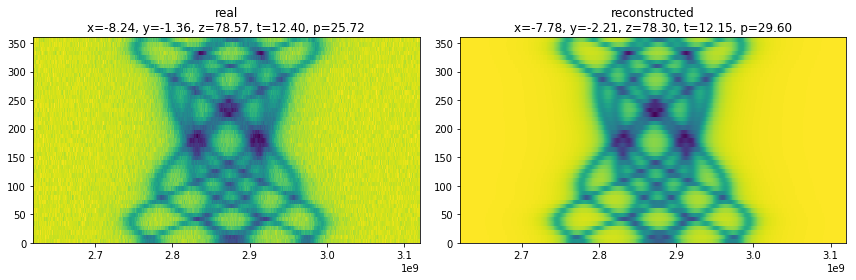

In [378]:
analyze_fit(Xo, Yo, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

In [379]:
Y_pred = model.predict(X_test)

Text(0.5,1,'error distribution on test set')

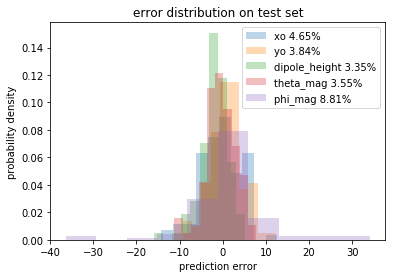

In [380]:
err = (Y_pred- Y_test)

for e, l in zip(err.T, labels):
    plt.hist(e*100, density=True, alpha=0.3, label = l+' {:0.2f}%'.format(100*np.std(e)))
plt.legend()
plt.xlabel('prediction error')
plt.ylabel('probability density')
plt.title('error distribution on test set')

#### on the test data

In [381]:
Xo = val_set['X'][0:n_max]
Yo = val_set['Y'][0:n_max]

particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


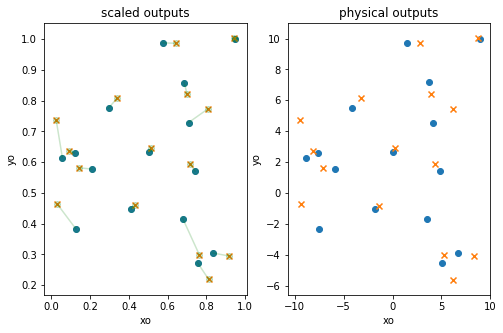

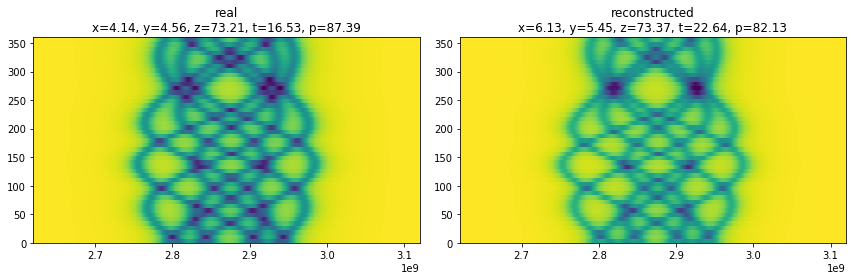

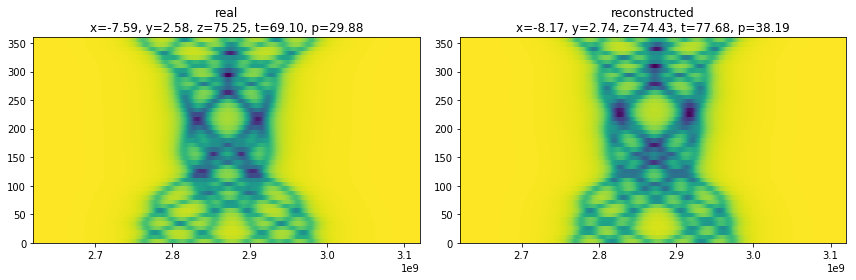

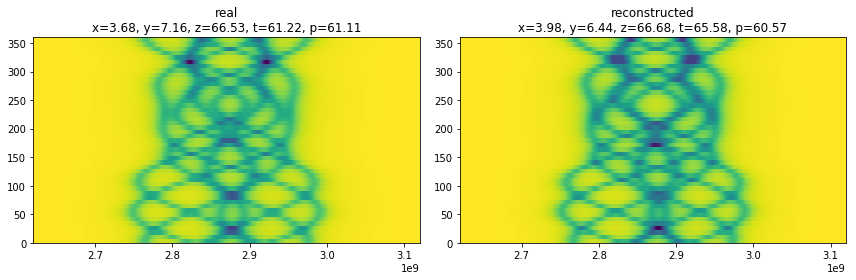

In [382]:
analyze_fit(Xo, Yo, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

In [383]:
val_set['Y'].max()

88.74239328788379

In [384]:
val_set['X'].min()

0.8096

#### on the test data - with noise

In [422]:
noise = 0.005*np.random.randn(*val_set['X'][0:n_max].shape)
Xo = val_set['X'][0:n_max]+noise
Yo = val_set['Y'][0:n_max]


particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


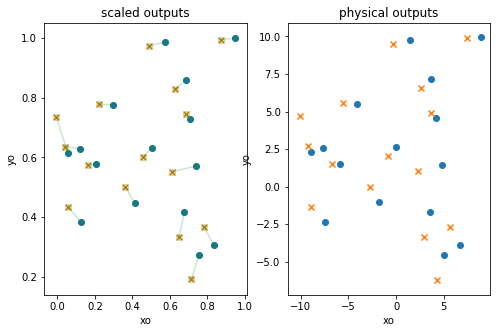

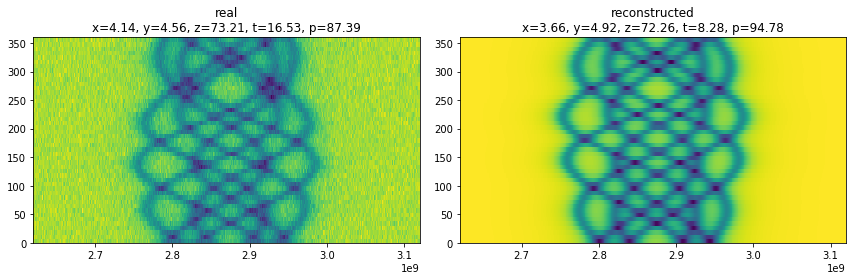

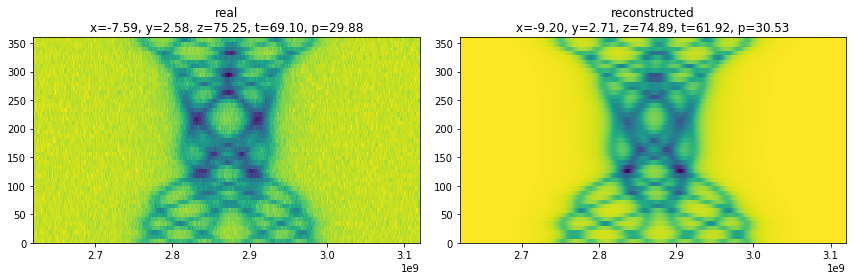

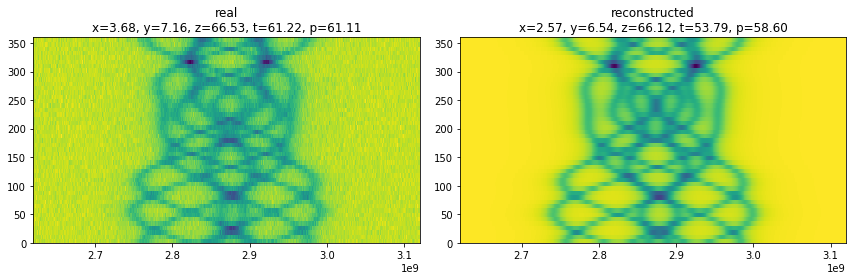

In [423]:
analyze_fit(Xo, Yo, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

In [414]:
# Xo, Yo = val_set['X'], val_set['Y']
x_shape = Xo.shape
Xs = x_scaler.transform(Xo.reshape(x_shape[0], -1).astype(np.float32)).reshape(x_shape)

Y_pred = model.predict(np.expand_dims(Xs, axis=-1))

Ys = y_scaler.transform(Yo)

Text(0.5,1,'error distribution on test set')

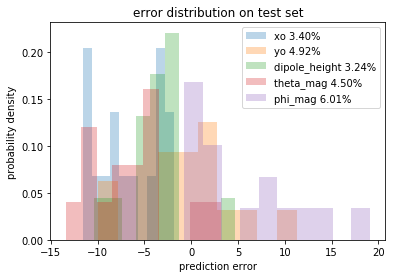

In [415]:
err = (Y_pred- Ys)

for e, l in zip(err.T, labels):
    plt.hist(e*100, density=True, alpha=0.3, label = l+' {:0.2f}%'.format(100*np.std(e)))
plt.legend()
plt.xlabel('prediction error')
plt.ylabel('probability density')
plt.title('error distribution on test set')

Text(0.5,1,'error distribution on test set')

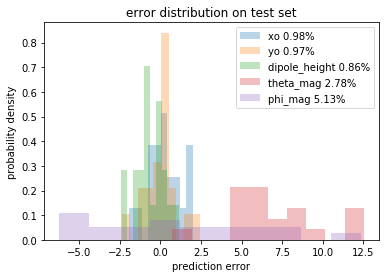

In [411]:
err = (y_scaler.inverse_transform(Y_pred)- y_scaler.inverse_transform(Ys))

for e, l in zip(err.T, labels):
    plt.hist(e, density=True, alpha=0.3, label = l+' {:0.2f}%'.format(np.std(e)))
plt.legend()
plt.xlabel('prediction error')
plt.ylabel('probability density')
plt.title('error distribution on test set')

##### scaled outputs

Text(0,0.5,'yo')

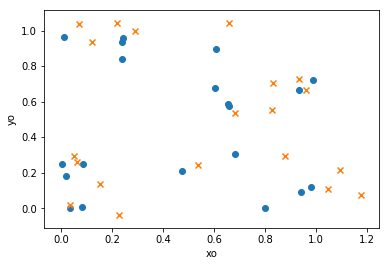

In [141]:
plt.scatter(val_set['Y'][:n_max, 0], val_set['Y'][:n_max, 1], marker='o')
plt.scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

Text(0,0.5,'yo')

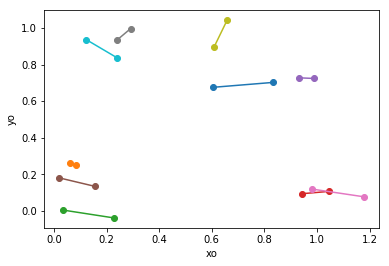

In [142]:
for i in range(10):

    plt.plot([val_set['Y'][i, 0], Y_predict[i, 0]], [val_set['Y'][i, 1], Y_predict[i, 1]], 'o-')
plt.xlabel('xo')
plt.ylabel('yo')

##### original outputs

Text(0,0.5,'yo')

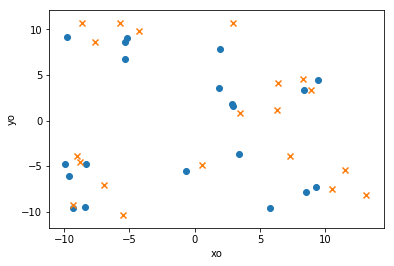

In [143]:
Y_real = y_scaler.inverse_transform(val_set['Y'][0:n_max])
Y_pred_real = y_scaler.inverse_transform(Y_predict[0:n_max])

plt.scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
plt.scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

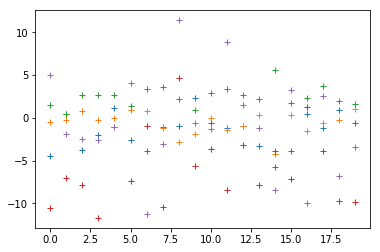

In [144]:
plt.plot(Y_real-Y_pred_real, '+')

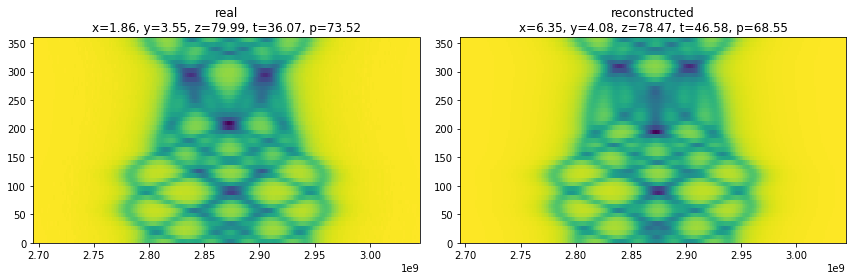

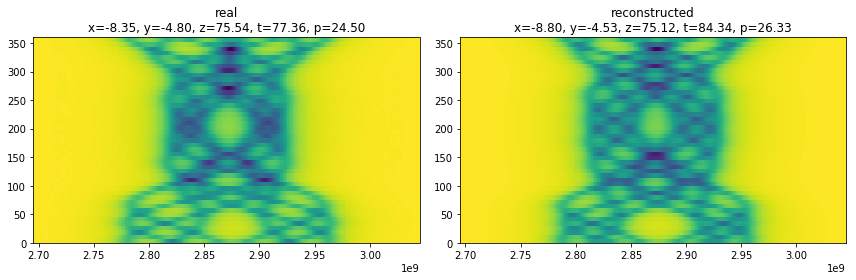

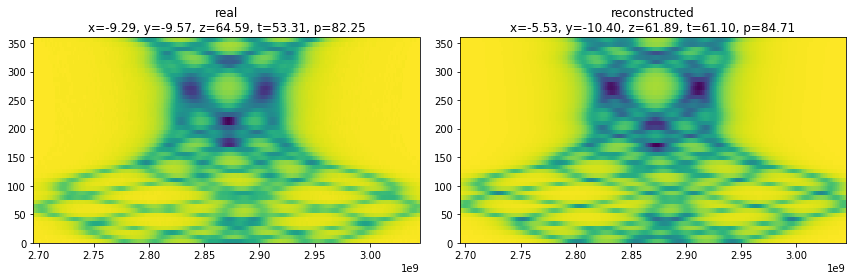

In [145]:
n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

x_shape = val_set['X'][0:n_plot, :,:,0].shape
X_real = x_scaler.inverse_transform(val_set['X'][0:n_plot].reshape(x_shape[0], -1)).reshape(x_shape)


for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    

    ax[0].pcolor(frequencies, angle, X_real[i])
    ax[0].set_title('real\n' + ', '.join([label_map[k] +'={:0.2f}' for k in labels]).format(*Y_real[i]))
    # and create the image, construction in second argument constructs the updates parameter dictionary
    img = create_image(*Y_pred_real[i, 0:2], **{**magnet_parameters, **{k:v for k, v in zip(labels[2:], Y_pred_real[i, 2:])}})
    ax[1].pcolor(frequencies, angle, img)
    ax[1].set_title('reconstructed\n' + ', '.join([label_map[k] +'={:0.2f}' for k in labels]).format(*Y_pred_real[i]))
    plt.tight_layout()

    

## Autoencoder

In [70]:
initializer = 'he_normal' # he_normal, glorot_normal
def define_encoder_block(x, num_filters, kernel_initializer=initializer):
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = MaxPooling2D()(x)
    return x


def define_decoder_block(x, num_filters, kernel_initializer=initializer):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(x)
    return x


def define_net(variational, height, width, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8):
    """Defines a (variational) encoder-decoder architecture.

    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.

    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """

    # Prepare the inputs.
    inputs = Input((height, width, 1))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs

    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters * 2)
    eblock3 = define_encoder_block(eblock2, start_filters * 4)
    eblock4 = define_encoder_block(eblock3, start_filters * 8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)

    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon

        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)

    dblock1 = define_decoder_block(embedding, start_filters * 8)
    dblock2 = define_decoder_block(dblock1, start_filters * 4)
    dblock3 = define_decoder_block(dblock2, start_filters * 2)
    dblock4 = define_decoder_block(dblock3, start_filters)
#     output = Conv2D(1, 1, activation='sigmoid')(dblock4)  # reduce down to one filter
    output = Conv2D(1, 1)(dblock4)  # reduce down to one filter

    # Define the models.
    decoder = Model(input=inputs_embedding, output=output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input=[inputs, condition], output=z)
        encoder_with_sampling_ext = Model(input=[inputs, condition], output=z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input=[inputs, condition], output=vae_out)
    else:
        encoder_with_sampling = Model(input=inputs, output=z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input=inputs, output=vae_out)

    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1, 2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss

    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')
#         vae.compile(loss='binary_crossentropy', optimizer='adam')

    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder




def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')


def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')
    
    
    


### train the autoencoder - using Keras API

In [71]:
X.shape

(5000, 48, 224, 1)

In [ ]:
# noise= np.random.normal(loc=0,scale=0.1, size=X[50,:,:,0].shape)
# i = 30
# plt.imshow(X[0,:,:,0])
# print(Y[i])

In [357]:
# X = X[:,0:32, 0:336, :]

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [74]:
img_height, img_width= X_train.shape[1:3]
img_height, img_width

(48, 224)

In [75]:
vae, encoder, decoder = define_net(
    False, img_height, img_width, batch_size=8, latent_dim=16, start_filters=32)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:101: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


done, 3287761 parameters.


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [76]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 224, 1)        0         
_________________________________________________________________
model_2 (Model)              (None, 16)                1343728   
_________________________________________________________________
model_1 (Model)              (None, 48, 224, 1)        1944033   
Total params: 3,287,761
Trainable params: 3,287,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [367]:
# history = vae.fit(X_train, X_train, batch_size=8, verbose=1, validation_data=(X_test, X_test), epochs=1)

In [368]:
X_train_noise = X_train + np.random.normal(loc=0,scale=0.1, size=X_train.shape)
X_test_noise = X_test + np.random.normal(loc=0,scale=0.1, size=X_test.shape)


In [78]:
history = None # reset history

In [80]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
#     LossHistory(),
    TQDMNotebookCallback(leave_inner=False, leave_outer=True),
#     TensorBoard(log_dir='/tmp/autoencoder')
]

use_noise = False
epochs = 15
batch_size = 32
if use_noise:

    history_run = vae.fit(X_train_noise,X_train_noise, epochs=epochs, batch_size=batch_size,verbose=0,
    #                     validation_split=0.2,
                        validation_data=(X_test_noise, X_test_noise),
                        callbacks=callbacks)
    
else:
    history_run = vae.fit(X_train,X_train, epochs=epochs, batch_size=batch_size,verbose=0,
    #                     validation_split=0.2,
                        validation_data=(X_test, X_test),
                        callbacks=callbacks)

# append to previous runs
if history == None:
    history = history_run.history
else:
    history = {k:history[k]+v for k, v in history_run.history.items()}


Text(0,0.5,'mean squared error')

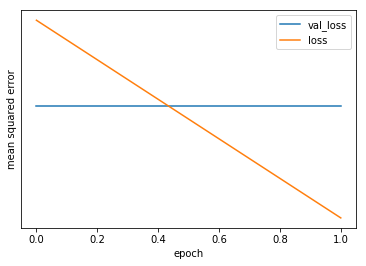

In [81]:
for value in ['val_loss', 'loss']:
    plt.semilogy(history[value],label = value)
#     plt.loglog(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

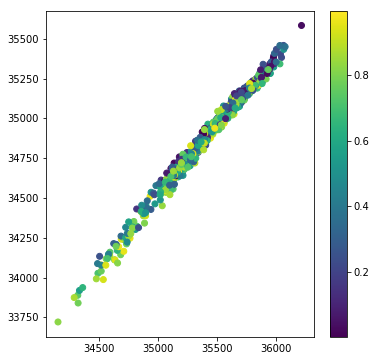

In [82]:
x_test_encoded = encoder.predict(X_test, batch_size=8)
plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test[:,0])
plt.colorbar()
plt.show()

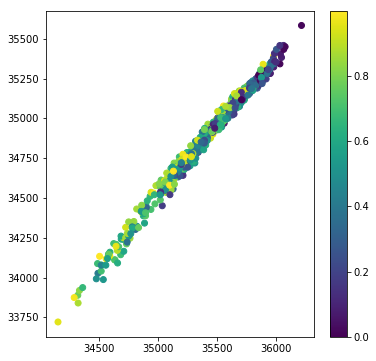

In [83]:
x_test_encoded = encoder.predict(X_test, batch_size=8)
plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test[:,1])
plt.colorbar()
plt.show()

### show original and predicted image side by side

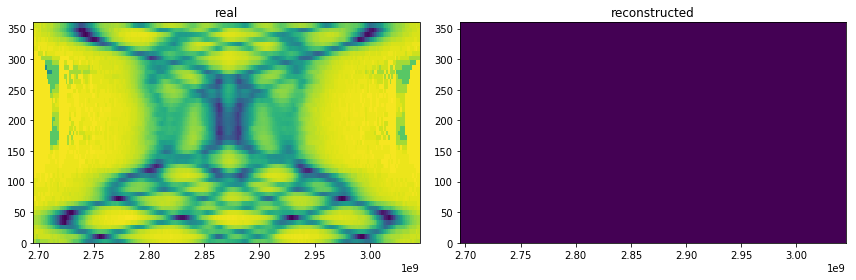

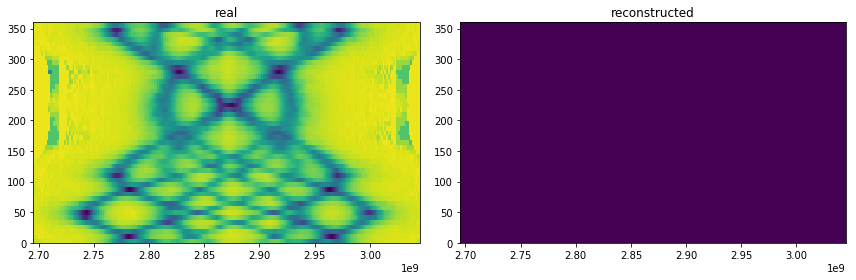

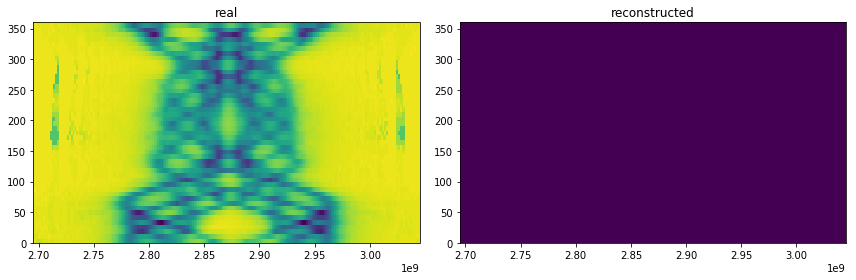

In [84]:
n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

# x_shape = X_train[0:n_plot, :,:,0].shape
# X_real = X_train[0:n_plot].reshape(x_shape[0], -1).reshape(x_shape)
X_real = X_train[0:n_plot]

frequencies = frequencies[0:X_real.shape[2]]
angle = angle[0:X_real.shape[1]]


def rescale(img, x_scaler):
    x_shape = img.shape
    return x_scaler.inverse_transform(img).reshape(x_shape)



for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    
    x_demo = X_real[i]
    pred = vae.predict(np.expand_dims(x_demo, axis=0))

    ax[0].pcolor(frequencies, angle, x_demo[:,:,0])
    ax[0].set_title('real')
    # and create the image, construction in second argument constructs the updates parameter dictionary
    ax[1].pcolor(frequencies, angle, pred[0,:,:,0])
    ax[1].set_title('reconstructed')
    plt.tight_layout()


### save autoencode

In [85]:
vae.save('../models/'+tag+'_vae.h5')
print('../models/' + time_stamp + '_' +tag+'_vae.h5 saved')

../models/20190126_shot_noise_0_xyztp_vae.h5 saved


### train a denoising autoencoder

In [86]:
# # add some noise
# noise_factor = 0.5
# X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
# X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
# X_val_noisy = val_data['X'] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_data['X'].shape)
# X_train_noisy = np.clip(X_train_noisy, 0., 1.)
# X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)
# X_val_noisy = np.clip(X_val_noisy, 0., 1.)

In [87]:
# vae, encoder, decoder = define_net(
#     False, img_height, img_width, batch_size=8, latent_dim=256, start_filters=8)

In [88]:
# class LossHistory(Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []

#     def on_batch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))

# # Set callback functions to early stop training and save the best model so far
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
#     LossHistory(),
#     TQDMNotebookCallback(leave_inner=False, leave_outer=True)
# ]

# history = vae.fit(X_train_noisy, X_train, epochs=32, batch_size=32,verbose=0,
# #                     validation_split=0.2,
#                     validation_data=(X_test_noisy, X_test),
#                     callbacks=callbacks)

## simple autoencoder

In [128]:

def make_autoencoder(width, height, inChannel, latent_dim=32):
    
#     first_filter = (3, 3 * (height//width))
#     first_strides = (1,  (height//width))
    
    first_filter = (3, 3 )
    first_strides = (1,  1)
    
    print('first_filter', first_filter)
    print('first_strides', first_strides)
    input_img = Input(shape = (width, height, inChannel))
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    encoder = Conv2D(32, first_filter,strides=first_strides, activation='relu', padding='same')(input_img) #28 x 28 x 32
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #14 x 14 x 32
    encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder) #14 x 14 x 64
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder) #7 x 7 x 128 (small and thick)
    
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder) #7 x 7 x 128 (small and thick)
    
    #bottle neck
    shape = encoder.shape.as_list()[1:]
    print('shape', shape)

    encoder = Flatten()(encoder)
    encoder = Dense(latent_dim)(encoder)
    
    decoded = Dense(np.prod(shape), activation='relu')(encoder)
    decoded = Reshape(shape)(decoded)
    

    #decoder
    decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded) #7 x 7 x 128
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded) #7 x 7 x 128
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded) # 14 x 14 x 64
    decoded = UpSampling2D((2,2))(decoded) # 28 x 28 x 64
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded) # 28 x 28 x 1
    decoded = Conv2D(1, (3, 3),padding='same')(decoded) # 28 x 28 x 1

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')  # RMSprop
    
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder, encoder



def make_autoencoder_batchnorm(width, height, inChannel, latent_dim=32):
    
#     first_filter = (3, 3 * (height//width))
#     first_strides = (1,  (height//width))
    
    first_filter = (3, 3 )
    first_strides = (1,  1)
    
    print('first_filter', first_filter)
    print('first_strides', first_strides)
    input_img = Input(shape = (width, height, inChannel))
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    encoder = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_img) #28 x 28 x 32
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #14 x 14 x 32
    
    encoder = Conv2D(64, (3, 3), padding='same')(encoder) #14 x 14 x 64
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    
    encoder = Conv2D(128, (3, 3),padding='same')(encoder) #7 x 7 x 128 (small and thick)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    encoder = Conv2D(256, (3, 3), padding='same')(encoder) #7 x 7 x 128 (small and thick)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)

    #decoder
    decoded = Conv2D(256, (3, 3), padding='same')(encoder) #7 x 7 x 128
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(128, (3, 3), padding='same')(decoded) #7 x 7 x 128
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(64, (3, 3), padding='same')(decoded) # 14 x 14 x 64
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    decoded = UpSampling2D((2,2))(decoded) # 28 x 28 x 64
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded) # 28 x 28 x 1
    decoded = Conv2D(1, (3, 3),padding='same')(decoded) # 28 x 28 x 1

    autoencoder = Model(input_img, decoded)
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')  # RMSprop
    
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder, encoder




# autoencoder = Sequential()

# # Encoder Layers
# autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=X_train2.shape[1:]))
# autoencoder.add(MaxPooling2D((2, 2), padding='same'))
# autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# autoencoder.add(MaxPooling2D((2, 2), padding='same'))
# autoencoder.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))

# # Flatten encoding for visualization
# # autoencoder.add(Flatten())
# # autoencoder.add(Reshape((4, 4, 8)))

# # Decoder Layers
# autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(8, (3, 3), activation='relu'))
# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))


autoencoder, encoder = make_autoencoder_batchnorm(*X.shape[1:], latent_dim=3)
autoencoder.summary()



first_filter (3, 3)
first_strides (1, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 48, 224, 1)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 48, 224, 32)       288       
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 224, 32)       128       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 224, 32)       0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 24, 112, 32)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 24, 112, 64)       18496     
_________________________________________________________________
batch_normalization_3 (Batch (None,

In [129]:

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
#     LossHistory(),
    TQDMNotebookCallback(leave_inner=False, leave_outer=True)
#     TensorBoard(log_dir='/tmp/autoencoder')
    
]

    

history = autoencoder.fit(X_train,X_train, epochs=3, batch_size=32,verbose=0,
                          shuffle=True,
                        validation_data=(X_test, X_test),
                        callbacks=callbacks)

In [130]:
autoencoder.history.history

{'val_loss': [0.13028488373756408, 0.09363042771816253, 0.0680879579782486],
 'loss': [6.6278586192727085, 0.02853505022989379, 0.020841548615031773]}

Text(0,0.5,'mean squared error')

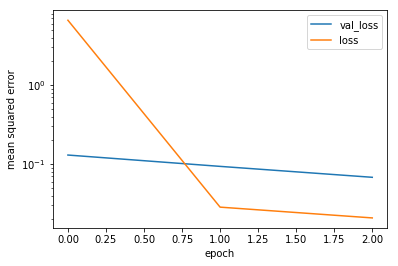

In [131]:
for value in ['val_loss', 'loss']:
    plt.semilogy(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

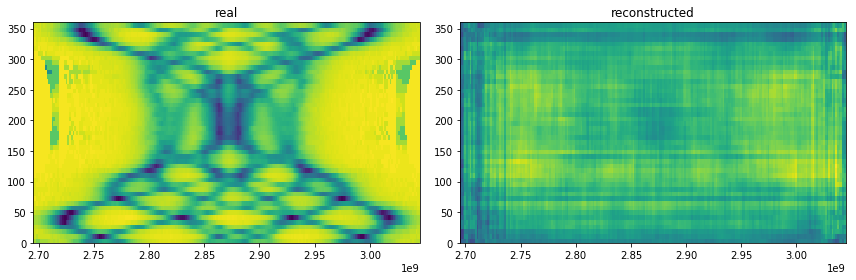

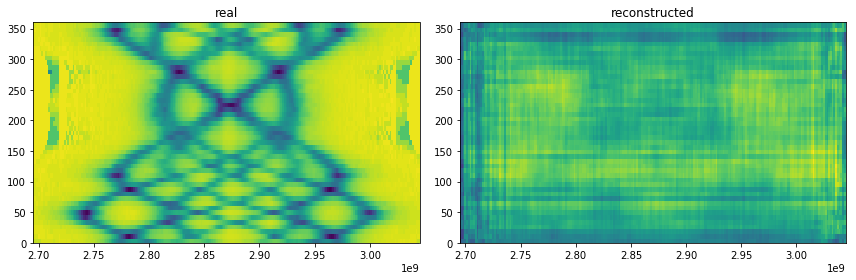

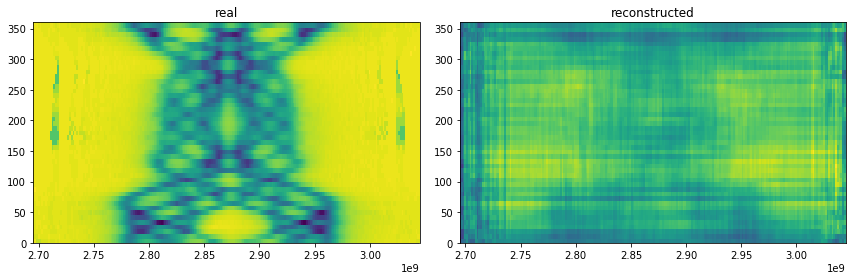

In [132]:
n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

# x_shape = X_train[0:n_plot, :,:,0].shape
# X_real = X_train[0:n_plot].reshape(x_shape[0], -1).reshape(x_shape)
X_real = X_train[0:n_plot]

frequencies = frequencies[0:X_real.shape[2]]
angle = angle[0:X_real.shape[1]]

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    
    x_demo = X_real[i]
    pred = autoencoder.predict(np.expand_dims(x_demo, axis=0))

    ax[0].pcolor(frequencies, angle, x_demo[:,:,0])
    ax[0].set_title('real')
    # and create the image, construction in second argument constructs the updates parameter dictionary
    ax[1].pcolor(frequencies, angle, pred[0,:,:,0])
    ax[1].set_title('reconstructed')
    plt.tight_layout()


### save simple AE

In [93]:
autoencoder.save('../models/'+tag+'_simple-ae.h5')
print('../models/' + time_stamp + '_' +tag+'_simple-ae.h5 saved')

../models/20190126_shot_noise_0_xyztp_simple-ae.h5 saved


### show encoded representation

In [95]:
# n = 10
# plt.figure(figsize=(20, 8))
# for i in range(n):
#     ax = plt.subplot(1, n, i)
#     plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

# Save current notebook as HTML

In [279]:
time_stamp = time.strftime('%Y%m%d-%H%M', time.localtime()) 
time_stamp

'20190128-2155'

In [280]:
from IPython.display import Javascript

def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [281]:
%%time
import time
save_notebook()
time.sleep(3)
current_file = 'CNN - reconstruct magnet position from esr spectra.ipynb'
output_file = '../html/' + time_stamp + '_' + tag + '.html' 
output_HTML(current_file, output_file)
print(output_file)

../html/20190128-2155_shot_noise_0_xyztp.html
CPU times: user 1.26 s, sys: 52.4 ms, total: 1.31 s
Wall time: 4.35 s
